# IMPLIED VOLATILITY

In [4]:
# Install relevant packages

# !pip install pip --upgrade
# !pip install fix-yahoo-finance==0.1.30
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
# import fix_yahoo_finance as yf
import random
from math import nan
# !pip install yfinance
import yfinance as yf
import datetime
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq
from scipy.optimize import brenth
from scipy.optimize import minimize
from scipy.optimize import fmin

In [5]:
# Change Company here 
ticker = '^SPX'
# Make it ticker object
comp = yf.Ticker(ticker)

In [6]:
# Stock Prices from Yahoo Finance
S = comp.history().iloc[-1,3] # Get current stock price for later #(start = start, end = end)

# # US libor rates effective from the 25/08/2021 - hardcoded directly from website
# rOvernight = 0.0008563
# rWeek = 0.0008788
# rMonth = 0.0009313
# r2Month = 0.0012175
# r3Month = 0.0012613
# r6Month = 0.0015150
# rYear = 0.0024325 

rOvernight = 0.0007575
rWeek = 0.0008413
rMonth = 0.0008463 
r2Month = 0.0009863 
r3Month = 0.0012075 
r6Month = 0.0015788 
rYear = 0.0023538  


time = np.array([1/365, 1/52, 1/12, 1/6, 1/4, 1/2, 1]) # time i.e. 1 week = 1/52, 1 month = 1/12
r = np.array( [rOvernight, rWeek, rMonth, r2Month, r3Month, r6Month, rYear]) # Libor rates put into an array
#Instantaneous rate 

In [7]:
S


4682.85009765625

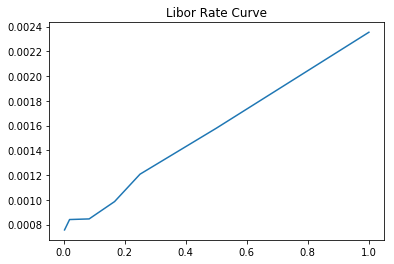

In [8]:
plt.plot(time,r)
plt.title("Libor Rate Curve")
plt.show()

In [9]:
pd.core.common.is_list_like = pd.api.types.is_list_like # Due to version difference
import pandas_datareader.data as web

In [10]:
# US Treasury Bills
from pandas_datareader.data import DataReader as dr
syms = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5']
yc = dr(syms, 'fred') # could specify start date with start param here
names = dict(zip(syms, ['1m', '3m', '6m', '1yr', '2yr', '3yr','5yr']))
yc = yc.rename(columns=names)
yc = yc[['1m', '3m', '6m','1yr', '2yr', '3yr', '5yr']]

USr = yc.iloc[-1,:].to_numpy()/100
r =  np.insert(r,len(r),USr[4]) # Adding US 2 year rate so we can linear interpolate later
r =  np.insert(r,len(r),USr[5]) # Adding US 3 year rate so we can linear interpolate later
r =  np.insert(r,len(r),USr[6]) # Adding US 5 year rate so we can linear interpolate later
time = np.insert(time, len(time), 2)
time = np.insert(time, len(time), 3)
time = np.insert(time, len(time), 5)

In [11]:
# Get expiries of available option prices
expiries = sorted(comp.options)

# Get Current Date and time to maturity (TTM)
CurrentDate = datetime.datetime.today()
ttm = np.ones(len(expiries))

#Converting expiry to TTM (Time to Maturity)
for i in range(len(expiries)):
        t = datetime.datetime.strptime(expiries[i], '%Y-%m-%d') - CurrentDate
        ttm[i] = t.days/365

In [12]:
# Interpolate r to the ttm we need (Linear Interpolation)
rNewi = np.interp(ttm, time, r) # These are interest rates we need

# Interpolate r to the ttm we need (Cubic Interpolation)
f = CubicSpline(time, r, bc_type="natural")
rNew = f(ttm) # These are interest rates we need

print("Libor time \n",time)
print("Yahoo Time to Maturity \n", ttm)
print("Libor r \n", r)
print("Yahoo rNew \n", rNew)
print("Yahoo rNew \n", rNewi)

Libor time 
 [2.73972603e-03 1.92307692e-02 8.33333333e-02 1.66666667e-01
 2.50000000e-01 5.00000000e-01 1.00000000e+00 2.00000000e+00
 3.00000000e+00 5.00000000e+00]
Yahoo Time to Maturity 
 [2.73972603e-03 8.21917808e-03 1.36986301e-02 2.19178082e-02
 2.73972603e-02 3.28767123e-02 4.10958904e-02 4.38356164e-02
 4.65753425e-02 5.20547945e-02 6.02739726e-02 6.57534247e-02
 7.12328767e-02 7.94520548e-02 9.04109589e-02 1.06849315e-01
 1.28767123e-01 1.47945205e-01 1.86301370e-01 2.13698630e-01
 2.63013699e-01 2.90410959e-01 3.39726027e-01 3.75342466e-01
 4.13698630e-01 4.54794521e-01 5.12328767e-01 5.89041096e-01
 6.24657534e-01 6.65753425e-01 7.61643836e-01 8.38356164e-01
 8.76712329e-01 9.34246575e-01 1.01095890e+00 1.08767123e+00
 1.18356164e+00 1.58630137e+00 2.08493151e+00 3.10136986e+00
 4.09863014e+00 4.34794521e+00 5.09589041e+00]
Libor r 
 [0.0007575 0.0008413 0.0008463 0.0009863 0.0012075 0.0015788 0.0023538
 0.0051    0.0083    0.0123   ]
Yahoo rNew 
 [0.0007575  0.00078827 0.

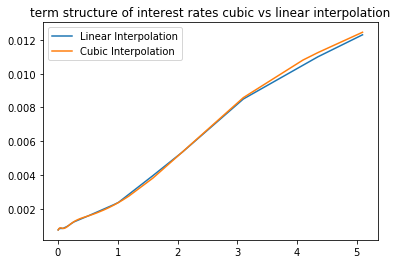

In [13]:
    #Plot of interpolated interest rate term
    plt.plot(ttm, rNewi,label="Linear Interpolation")
    plt.plot(ttm, rNew,label ="Cubic Interpolation")
    plt.legend()
    plt.title("term structure of interest rates cubic vs linear interpolation")
    plt.show()

# Volatility Smile for Calls & Puts

In [14]:
expiries[-1]
tempo = datetime.datetime.strptime(expiries[-1], '%Y-%m-%d') - CurrentDate
tempo.days/365
len(expiries)

43

In [15]:
len(expiries)

43

In [16]:
# as at 16/09/2021 - DO NOT CHANGE
calls1 = comp.option_chain(date = expiries[24]).calls # Pick the fixed ttm you want
puts1 = comp.option_chain(date = expiries[24]).puts
calls2 = comp.option_chain(date = expiries[33]).calls # Pick the fixed ttm you want
puts2 = comp.option_chain(date = expiries[33]).puts
calls3 = comp.option_chain(date = expiries[37]).calls # Pick the fixed ttm you want
puts3 = comp.option_chain(date = expiries[37]).puts

In [58]:
choose = 1
if choose == 1:
    calls = calls1 #short term
    puts = puts1
    index = 24
if choose == 2:
    calls = calls2 #medium term
    puts = puts2
    index = 33
if choose == 3:
    calls =calls3 #long term
    puts = puts3
    index = 37

In [59]:
lowerlim

200.0

In [60]:
# index = 38 #index for which maturity to extract data
# calls = comp.option_chain(date = expiries[index]).calls # Pick the fixed ttm you want
# puts = comp.option_chain(date = expiries[index]).puts
# strikes = calls.index.get_level_values("Strike").values
strikes = calls["strike"].values
yIV = calls["impliedVolatility"].values
price = calls["lastPrice"].values

pstrikes = puts["strike"].values
pyIV = puts["impliedVolatility"].values
pprice = puts["lastPrice"].values

#For graphing we need the overlap to compare effectively - will be our x-axis limits
if len(strikes) != len(pstrikes):
    lowerlim = max(min(strikes),min(pstrikes))
    upperlim = min(max(strikes),max(pstrikes))
    

In [61]:
# Printing Parameters used for smile:
print("r: ", rNew[index])
print("S: ", S)
print("time to maturity (years): ", ttm[index],"\ntime to maturity (days): ", ttm[index]*365)
print("IV: \n", yIV)
print("Strikes: \n", strikes)

r:  0.0014801626757521263
S:  4682.85009765625
time to maturity (years):  0.4136986301369863 
time to maturity (days):  151.0
IV: 
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-0

## Yahoo Volatility Smile

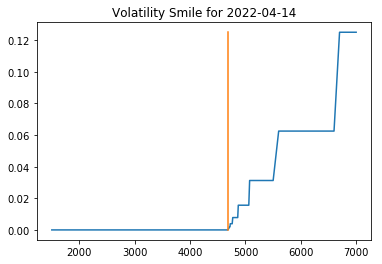

In [62]:
figure = plt.figure()
plt.plot(strikes, yIV)
plt.title("Volatility Smile for " + str(expiries[index]))
plt.plot([S]*len(yIV),yIV) #Share price - at the money
plt.show()

## Black Scholes + Newton Raphson functions

In [63]:
def bs(S, K, T, r, sigma,option="call"):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    put = call + ( np.exp(-r * T) * K ) - S
    if option == "call":
        return call
    elif option == "put":
        return put

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)


def impliedVol(target, S, K, T, r, sigma=0.5, option ="call", tol=0.0001, max_iterations=100):
    '''
    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''

    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = bs(S, K, T, r, sigma, option) - target

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            print("found on {}th iteration".format(i))
            print("difference is equal to {}\n".format(diff))
            break

        ### use newton rapshon to update the estimate
#         print(bs_vega(S, K, T, r, sigma))
        sigma = sigma - diff / bs_vega(S, K, T, r, sigma)
#         print(sigma)
    return sigma

# Implied Volatility using Newton Rapshon only

In [953]:
callData[2][0]

0.2275229446733793

In [442]:
valx = np.zeros(len(callData[2]))
for i in range(len(callData[2])):
    valx[i]=bs_vega(S,pstrikes[:][i],ttm[index],rNew[index],callData[2][i])
valy = np.zeros(len(callData_1[2]))
for i in range(len(callData_1[2])):
    valy[i]=bs_vega(S,pstrikes[:][i],ttm[index],rNew[index],callData_1[2][i])

In [443]:
valx

array([1.17937051e-15, 3.32226022e-05, 1.72974382e-03, 2.35576609e-05,
       2.00875458e-04, 1.62665711e-02, 3.45410577e-04, 2.03968200e-03,
       5.17134303e-05, 5.23295847e-02, 4.65667610e+00, 1.33316493e+01,
       5.68016652e-02, 1.03967708e+01, 1.37281154e+01, 1.22422463e+01,
       1.60668234e+01, 2.09145221e+01, 3.62659925e+01, 8.23380237e+01,
       1.03602322e+02, 1.76216750e+02, 1.90981861e+02, 1.19509130e+02,
       2.13015965e+02, 2.53085077e+02, 7.23194246e+01, 1.98110984e+02,
       1.71979101e+02, 2.14028993e+02, 2.24591168e+02, 2.40989681e+02,
       2.87276897e+02, 2.66586032e+02, 2.67054189e+02, 2.81072700e+02,
       2.86447670e+02, 3.34779458e+02, 3.09639826e+02, 3.67152235e+02,
       4.73788302e+02, 3.44036074e+02, 4.17382344e+02, 4.47580880e+02,
       4.65501429e+02, 5.61046939e+02, 4.71016247e+02, 5.43719788e+02,
       5.73054312e+02, 6.27266046e+02, 6.24918720e+02, 6.56694989e+02,
       7.04996877e+02, 7.00412733e+02, 8.23429766e+02, 8.94358746e+02,
      

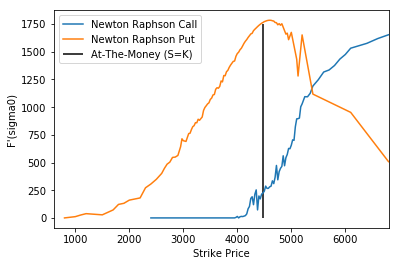

In [447]:
plt.plot(callData[0], valx,label="Newton Raphson Call")
plt.plot(callData_1[0], valy,label="Newton Raphson Put")
# plt.plot([strikes[0],strikes[len(strikes)-1]],[callData[2][0],callData[2][len(strikes)-1]],"ro",label="Call data stops")
# plt.plot([pstrikes[0],pstrikes[len(pstrikes)-1]],[callData_1[2][0],callData_1[2][len(pstrikes)-1]],"bo",label="Put data stops")
# plt.title("Strikes vs F'()")
plt.vlines(S,0,1750,label="At-The-Money (S=K)")
plt.xlim((lowerlim,upperlim))
plt.xlabel('Strike Price')
plt.ylabel("F'(sigma0)")
plt.legend()
plt.show()

In [438]:
# IV for each strike price at the choosen maturity date
sigmaImplied = np.zeros(len(price))
sigmaImplied_1 = np.zeros(len(pprice)) #variable to see effects of tol & max_iterations 
for i in range(len(price)):
    sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0001,max_iterations=1000)
#     sigmaImplied_1[i] = impliedVol(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0001,max_iterations=1000,option="put")
for i in range(len(pprice)):
#     sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0001,max_iterations=1000)
    sigmaImplied_1[i] = impliedVol(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0001,max_iterations=1000,option="put")


C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\arinj

found on 4th iteration
difference is equal to 2.3115922886063345e-05

found on 4th iteration
difference is equal to 1.838293428590987e-08

found on 4th iteration
difference is equal to 2.751221472863108e-11

found on 4th iteration
difference is equal to 4.582375368045177e-08

found on 4th iteration
difference is equal to 1.689727469056379e-09

found on 3th iteration
difference is equal to 3.230762661132758e-05

found on 4th iteration
difference is equal to 9.201244210998993e-09

found on 4th iteration
difference is equal to 2.650267560966313e-09

found on 4th iteration
difference is equal to 3.2227637802861864e-07

found on 3th iteration
difference is equal to 7.000496646014653e-05

found on 3th iteration
difference is equal to 1.2657143315664143e-06

found on 3th iteration
difference is equal to 2.1338837541406974e-07

found on 4th iteration
difference is equal to 3.211653165635653e-10

found on 3th iteration
difference is equal to 8.182771580322878e-07

found on 3th iteration
differe

In [439]:
# get rid of nans so we can plot
ind = np.where(~np.isnan(sigmaImplied))
ind_1 = np.where(~np.isnan(sigmaImplied_1))
# view our estimates
print(sigmaImplied)
print(sigmaImplied_1)

[       nan 0.34710383 0.29693517 0.2940336  0.23858004        nan
 0.23865773 0.23359137 0.17780147 0.17805497 0.14806836 0.18088034
 0.21380144 0.22199274 0.14003948 0.18838931 0.18727059 0.17843421
 0.17722683 0.17606031 0.18187583 0.19869815 0.19917146 0.21418408
 0.20943375 0.18468636 0.20626358 0.20685886 0.15451106 0.18521035
 0.17495397 0.18034396 0.17836552 0.17747319 0.18217657 0.17383438
 0.16960604 0.16782017 0.16015885 0.16369582 0.15534842 0.15976819
 0.17113099 0.1475505  0.15335643 0.1528492  0.15053523 0.15840083
 0.14184187 0.14606028 0.1447033  0.14625677 0.14076651 0.13930212
 0.13964651 0.13370139 0.14270362 0.14578601 0.13974505 0.13409362
 0.14095921 0.1376188  0.13994978 0.13236725 0.12942245 0.13163237
 0.13279898 0.13697959 0.13116988 0.12975124 0.13302232 0.1327664
 0.13906001 0.14336148 0.15113476 0.15874011 0.15818447 0.16702487
 0.17479147]
[       nan 0.64867995 0.60018759 0.57460798 0.56625697 0.50158692
 0.47847583 0.46691857 0.44431721 0.43576329 0.419

In [440]:
# Get values in dataframe to plot easily
callData = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1 = pd.concat([pd.Series(pstrikes[ind_1]), pd.Series(pprice[ind_1]), pd.Series(sigmaImplied_1[ind_1])], axis=1)

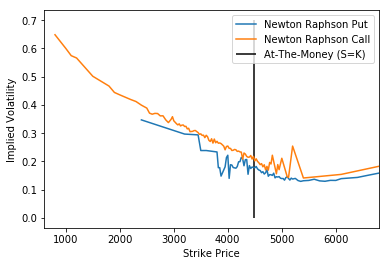

In [441]:
plt.plot(callData[0], callData[2],label="Newton Raphson Put")
plt.plot(callData_1[0], callData_1[2],label="Newton Raphson Call")
# plt.plot(strikes, yIV,label="Yahoo")
plt.vlines(S,0,0.7,label="At-The-Money (S=K)")
# plt.title()
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.xlim(lowerlim,upperlim)
# plt.plot([strikes[0],strikes[len(strikes)-1]],[callData[2][0],callData[2][len(strikes)-1]],"ro",label="Call data stops")
# plt.plot([pstrikes[0],pstrikes[len(pstrikes)-1]],[callData_1[2][0],callData_1[2][len(pstrikes)-1]],"bo",label="Put data stops")

plt.legend()
plt.show()

### Increasing iterations does not impact volatility estimates at all, but increasing tolerance does improve results upto a certain extent. Still nans at tails.

# Implied Volatility with Newton Raphson w/ high tolerance & Bisection

In [407]:
def ivVer2(target, S, K, T, r, sigma=0.5, option ="call", tol=0.000001, max_iterations=100,tune_limit = 10):
    '''
    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''
    sigma0=sigma #placeholder for initial value in case of nan
#     a = 0.0001   #lower_bound 
#     b = 1       #upper_bound
    count = 0
    while count < (max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = bs(S, K, T, r, sigma, option) - target

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
#             print("found on {}th iteration".format(i))
#             print("target price difference is equal to {}\n".format(diff))
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / bs_vega(S, K, T, r, sigma)
        
        
        ## Bisection kicks in to deal with nans 

        if (np.isnan(sigma)==True):
            tune = 0.05 # Need starting tune
            a = sigma0-tune
            b = sigma0+tune
            
#             if a < 0:    #prevent lower bound to be negative
#                 a = 0.00000000000000000001
            sigma = sigma0 
            count = 0      #restarts calculations
            # If solution exists, it will return here


            diff1 = bs(S, K, T, r, a, option) - target
            diff2 = bs(S, K, T, r, b, option) - target
            
            # possibility of double or more roots or no root in interval
            # Deal with possibility of no roots (Increase Interval)
            tune1 = 0.01
            while (diff1*diff2>0) and (tune1<tune_limit):
                
                tune1 += 0.5 #Increasing from both sides
                a1 = sigma0 - tune1
#                 if a1 < 0:
#                     a1 = 0.00000000000000000001
                b1 = sigma0 + tune1
                diff2 = bs(S, K, T, r, b1, option) - target
                diff1 = bs(S, K, T, r, a1, option) - target
                if (diff1*diff2 < 0):  
                    b = b1
                    a = a1
                    print("hallelujah1")
            
            # Lets deal with possibility of double root here (Decrease Interval)
            tester = 1
            tester_limit = 50
            gridcheck = np.linspace(0,b-a,tester_limit)
            for i in gridcheck:
                difftest = bs(S, K, T, r, a+i, option) - target
                while ((diff1*difftest < 0) and (diff2*difftest < 0) and (tester < tester_limit)): 
                    print("case2 started")
                    length = b-a 
                    bnew = b * (1 - (length)*(tester/tester_limit)) #decrease interval 2% each time from RHS
                    diff2 = bs(S, K, T, r, bnew, option) - target
                    tester+=1
                    if (((diff1*difftest > 0) and (diff2*difftest < 0)) or ((diff1*difftest < 0) and (diff2*difftest > 0)))  :  
                        b = bnew   
#                         difftest = bs(S, K, T, r, (a+b)/2, option) - target
                        print("hallelujah2")

            
            if diff1*diff2 >0:
                print("FAILED")
                return np.nan
            
            while count < (max_iterations):
                    # Only Bisection
                    diff = bs(S, K, T, r, sigma, option) - target
                    diff1 = bs(S, K, T, r, a, option) - target
                    
                    if abs(diff) < tol:
                        print("BOO    \n  found on {}th iteration".format(i))
                        print("BOO      target price difference is equal to {}\n".format(diff))
                        return sigma   
                    if diff1*diff > 0: 
                        a = sigma
                    elif diff1*diff < 0:
                        b = sigma
#                     if abs(b - a) < 0.000000001: # Interval of vol estimates almost equal (x's)
#                         print("volatility estimates converged")
#                         return sigma
                    
                    sigma = a + (b-a)/2   # mid vol for next iteration if no tolerance criteria broken

                    # THIS IS THE HYBRID PART - USE LATER
#                     if ((sigma1 - diff / bs_vega(S, K, T, r, sigma1)) < b) or ((sigma1 - diff / bs_vega(S, K, T, r, sigma1)) > a):
#                         sigma= (sigma1 - diff / bs_vega(S, K, T, r, sigma1))
#                     else:
#                         sigma = sigma1

                    count += 1
    
     
                    
#                     print("Sigma: {}\n a: {}\n b: {}\n tune: {}\n".format(sigma,a,b,tune1))    
            return sigma # If solution exists or not, it will resturn here
            # if solution does not exist = tried different starting points and bounded between a and b not working
                    
        count += 1
    return sigma

In [408]:
# IV for each strike price at the choosen maturity date
sigmaImplied = np.zeros(len(price))
sigmaImplied_1 = np.zeros(len(pprice)) #variable to see effects of tol & max_iterations 
for i in range(len(price)):
    sigmaImplied[i] = ivVer2(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.000001,max_iterations=100,tune_limit=10)
#     sigmaImplied_1[i] = ivVer2(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=0.1,tol=0.0000001,max_iterations=1000,tune_limit=10,option="put")
for i in range(len(pprice)):
#     sigmaImplied[i] = ivVer2(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=0.1,tol=0.000001,max_iterations=100,tune_limit=10)
    sigmaImplied_1[i] = ivVer2(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0000001,max_iterations=1000,tune_limit=10,option="put")

In [409]:
# get rid of nans so we can plot
ind = np.where(~np.isnan(sigmaImplied))
ind_1 = np.where(~np.isnan(sigmaImplied_1))
# view our estimates
print(sigmaImplied)
print(sigmaImplied_1)

[0.23487668 0.16870196 0.16095265 0.17309131 0.17047782 0.18155701
 0.19090023 0.18389718 0.1777946  0.1764983  0.17652853 0.17372726
 0.16451895 0.13939892 0.13754868 0.14591744 0.14548572 0.14069812
 0.12421056 0.12265935 0.13312319 0.13178348]
[0.45612587 0.42157236 0.42317355 0.40573289 0.39721734 0.39020874
 0.39086392 0.37808405 0.37565374 0.35335674 0.35603866 0.3381109
 0.34107903 0.33011178 0.32138059 0.31611075 0.31503977 0.31526229
 0.30850444 0.27456721 0.27940944 0.23921221 0.2392411  0.23860259
 0.24974412 0.23599015 0.23811508 0.23202615 0.22787049 0.2242478
 0.20879393 0.209198   0.20128313 0.21567062 0.20124239 0.20074963
 0.19713686 0.18140967 0.18059597 0.18903881 0.19760622 0.15506199
 0.14880249 0.14694748 0.1663475  0.15448704 0.15460207]


In [410]:
# Get values in dataframe to plot easily
callData = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1 = pd.concat([pd.Series(pstrikes[ind_1]), pd.Series(pprice[ind_1]), pd.Series(sigmaImplied_1[ind_1])], axis=1)

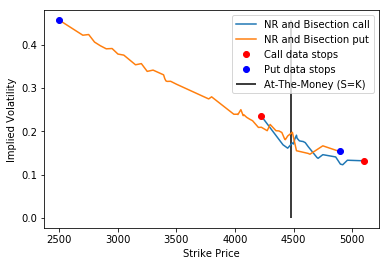

In [411]:
plt.plot(callData[0], callData[2],label="NR and Bisection call")
plt.plot(callData_1[0], callData_1[2],label="NR and Bisection put")
plt.vlines(S,0,(max(callData_1[2]),max(yIV)),label="At-The-Money (S=K)")
plt.plot([strikes[0],strikes[len(strikes)-1]],[callData[2][0],callData[2][len(strikes)-1]],"ro",label="Call data stops")
plt.plot([pstrikes[0],pstrikes[len(pstrikes)-1]],[callData_1[2][0],callData_1[2][len(pstrikes)-1]],"bo",label="Put data stops")
# plt.title("Volatility Curve")
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
# plt.ylim((0,1))
# plt.xlim(lowerlim,upperlim)
plt.legend()
plt.show()

### Bisection doesnt know which root to go for, instead focus on starting sigma value using newton raphson and bisection to see how it affects

# Implied Volatility w/ Newton Raphson starting from min(strike - stock price) and algorithm goes both tails taking previous sigmas

In [448]:
def ivVer3(target, S, K, T, r, sigma=0.5, option ="call", tol=0.000001, max_iterations=100,tune_limit = 10):
    '''
    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''
    sigma0=sigma #placeholder for initial value in case of nan
#     a = 0.0001   #lower_bound 
#     b = 1       #upper_bound
    count = 0
    while count < (max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = bs(S, K, T, r, sigma, option) - target

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
#             print("found on {}th iteration".format(i))
#             print("target price difference is equal to {}\n".format(diff))
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / bs_vega(S, K, T, r, sigma)
        
        
        ## Bisection kicks in to deal with nans 

        if (np.isnan(sigma)==True):
            tune = 0.05 # Need starting tune
            a = sigma0-tune
            b = sigma0+tune
            
#             if a < 0:    #prevent lower bound to be negative
#                 a = 0.00000000000000000001
            sigma = sigma0 
            count = 0      #restarts calculations
            # If solution exists, it will return here


            diff1 = bs(S, K, T, r, a, option) - target
            diff2 = bs(S, K, T, r, b, option) - target
            
            # possibility of double or more roots or no root in interval
            # Deal with possibility of no roots (Increase Interval)
            tune1 = 0.01
            while (diff1*diff2>0) and (tune1<tune_limit):
                
                tune1 += 0.05 #Increasing from both sides
                a1 = sigma0 - tune1
#                 if a1 < 0:
#                     a1 = 0.00000000000000000001
                b1 = sigma0 + tune1
                diff2 = bs(S, K, T, r, b1, option) - target
                diff1 = bs(S, K, T, r, a1, option) - target
                if (diff1*diff2 < 0):  
                    b = b1
                    a = a1
                    print("hallelujah1")
            
            # Lets deal with possibility of double root here (Decrease Interval)
            tester = 1
            tester_limit = 50
            gridcheck = np.linspace(0,b-a,tester_limit)
            for i in gridcheck:
                difftest = bs(S, K, T, r, a+i, option) - target
                while ((diff1*difftest < 0) and (diff2*difftest < 0) and (tester < tester_limit)): 
                    print("case2 started")
                    length = b-a 
                    bnew = b * (1 - (length)*(tester/tester_limit)) #decrease interval 2% each time from RHS
                    diff2 = bs(S, K, T, r, bnew, option) - target
                    tester+=1
                    if (((diff1*difftest > 0) and (diff2*difftest < 0)) or ((diff1*difftest < 0) and (diff2*difftest > 0)))  :  
                        b = bnew   
#                         difftest = bs(S, K, T, r, (a+b)/2, option) - target
                        print("hallelujah2")

            
            if diff1*diff2 >0:
                print("FAILED")
                return np.nan
            
            while count < (max_iterations):
                    # Only Bisection
                    diff = bs(S, K, T, r, sigma, option) - target
                    diff1 = bs(S, K, T, r, a, option) - target
                    
                    if abs(diff) < tol:
                        print("BOO    \n  found on {}th iteration".format(i))
                        print("BOO      target price difference is equal to {}\n".format(diff))
                        return sigma   
                    if diff1*diff > 0: 
                        a = max(sigma,a)
                    elif diff1*diff < 0:
                        b = min(sigma,b)
                    if abs(b - a) < 0.00000001: # Interval of vol estimates almost equal (x's)
                        print("volatility estimates converged")
                        return sigma
                    
                    sigma1 = a + (b-a)/2   # mid vol for next iteration if no tolerance criteria broken

                    # THIS IS THE HYBRID PART - USE LATER
#                     if ((sigma - diff / bs_vega(S, K, T, r, sigma)) < b) or ((sigma - diff / bs_vega(S, K, T, r, sigma)) > a):
#                         sigma= (sigma - diff / bs_vega(S, K, T, r, sigma))
#                     else:
#                         sigma = sigma1
                    sigma = sigma1
                    count += 1
    
     
                    
#                     print("Sigma: {}\n a: {}\n b: {}\n tune: {}\n".format(sigma,a,b,tune1))    
            return sigma # If solution exists or not, it will resturn here
            # if solution does not exist = tried different starting points and bounded between a and b not working
                    
        count += 1
    return sigma

In [449]:
pstrikes
psigma0

0.19760617776544054

In [484]:
startindex = abs(S-strikes).argmin() #starting index
pstartindex = abs(S-pstrikes).argmin() #starting index
# IV for each strike price at the choosen maturity date
sigmaImplied = np.zeros(len(price))
sigmaImplied_1 = np.zeros(len(pprice)) #variable to see effects of tol & max_iterations 
#Initial sigma 
sigma0 = impliedVol(target=price[startindex], S=S, K=strikes[startindex], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0001,max_iterations=100)
psigma0 = impliedVol(target=pprice[pstartindex], S=S, K=pstrikes[pstartindex], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0001,max_iterations=100,option="put")
sigmaImplied[startindex] = sigma0
sigmaImplied_1[pstartindex] = psigma0
restart_limit = 20
#Right Tail
for i in range(startindex+1,len(price)):
    
        sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1],tol=0.0001,max_iterations=100)
#         sigmaImplied_1[i] = impliedVol(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1],tol=0.000000001,max_iterations=100,option="put")

        restart = 0 # Restart with more previous estimates
        while ((np.isnan(sigmaImplied[i])==True) or (sigmaImplied[i]<0.0001)) and (restart<restart_limit):
            back =0
            while np.isnan(sigmaImplied[i-1-back]) == True:
                back+=1
            sigmaImplied[i] = ivVer3(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1-back]+restart/100,tol=0.0001,max_iterations=100,tune_limit=10) 
#             sigmaImplied_1[i] = ivVer3(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i-1-back]+restart/100,tol=0.000000001,max_iterations=100,tune_limit=10,option="put")

            restart += 1

#Left Tail
for i in range(startindex-1,-1,-1):
        sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i+1],tol=0.0001,max_iterations=100)
#         sigmaImplied_1[i] = impliedVol(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i+1],tol=0.000000001,max_iterations=100,option="put")

        restart = 0 # Restart with more previous estimates
        while ((np.isnan(sigmaImplied[i])==True) or (sigmaImplied[i]<0.0001)) and (restart<restart_limit):
            
            back =0
            while np.isnan(sigmaImplied[i+1+back]) == True:
                back+=1
                
            sigmaImplied[i] = ivVer3(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i+1+back],tol=0.0001,max_iterations=50,tune_limit=10) 
#             sigmaImplied_1[i] = ivVer3(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i+1+back]+restart/10,tol=0.000000001,max_iterations=50,tune_limit=10,option="put")
            restart += 1

#PUT OPTION
#Right Tail
for i in range(pstartindex+1,len(pprice)):
    
#         sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1],tol=0.0001,max_iterations=100)
        sigmaImplied_1[i] = impliedVol(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i-1],tol=0.000000001,max_iterations=100,option="put")

        restart = 0 # Restart with more previous estimates
        while ((np.isnan(sigmaImplied_1[i])==True) or (sigmaImplied_1[i]<0.0001)) and (restart<restart_limit):
            back =0
            while np.isnan(sigmaImplied_1[i-1-back]) == True:
                back+=1
#             sigmaImplied[i] = ivVer3(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1-back]+restart/100,tol=0.0001,max_iterations=100,tune_limit=10) 
            sigmaImplied_1[i] = ivVer3(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i-1-back]+restart/100,tol=0.000000001,max_iterations=100,tune_limit=10,option="put")

            restart += 1

#Left Tail
for i in range(pstartindex-1,-1,-1):
#         sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i+1],tol=0.0001,max_iterations=100)
        sigmaImplied_1[i] = impliedVol(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i+1],tol=0.000000001,max_iterations=100,option="put")

        restart = 0 # Restart with more previous estimates
        while ((np.isnan(sigmaImplied_1[i])==True) or (sigmaImplied_1[i]<0.0001)) and (restart<restart_limit):
            
            back =0
            while np.isnan(sigmaImplied_1[i+1+back]) == True:
                back+=1
                
#             sigmaImplied[i] = ivVer3(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i+1+back],tol=0.0001,max_iterations=50,tune_limit=10) 
            sigmaImplied_1[i] = ivVer3(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i+1+back]+restart/10,tol=0.000000001,max_iterations=50,tune_limit=10,option="put")
            restart += 1

found on 2th iteration
difference is equal to -6.096683301848316e-05

found on 2th iteration
difference is equal to -5.423650637226274e-05

found on 1th iteration
difference is equal to -5.581099526352773e-05

found on 2th iteration
difference is equal to -1.7053025658242404e-13

found on 2th iteration
difference is equal to 5.684341886080801e-13

found on 2th iteration
difference is equal to 1.1368683772161603e-12

found on 2th iteration
difference is equal to 4.75210981676355e-11

found on 2th iteration
difference is equal to 1.1368683772161603e-12

found on 1th iteration
difference is equal to 8.8457454694435e-08

found on 2th iteration
difference is equal to 1.4691181604575831e-10

found on 2th iteration
difference is equal to 8.215974389713665e-08

found on 3th iteration
difference is equal to 2.0733637029479723e-11

found on 2th iteration
difference is equal to 1.2819910466532747e-08

found on 2th iteration
difference is equal to 1.0828593929090857e-05

found on 2th iteration
dif

In [485]:
# get rid of nans so we can plot
ind = np.where(~np.isnan(sigmaImplied))
ind_1 = np.where(~np.isnan(sigmaImplied_1))
# view our estimates
print(sigmaImplied)
print(sigmaImplied_1)

[0.23487668 0.16870196 0.16095265 0.17309126 0.17047778 0.18155701
 0.19090023 0.18389718 0.1777946  0.1764983  0.17652853 0.17372726
 0.16451895 0.13939892 0.13754868 0.14591745 0.14548572 0.14069813
 0.12421056 0.12265935 0.13312319 0.13178348]
[0.45612587 0.42157236 0.42317355 0.40573289 0.39721734 0.39020874
 0.39086392 0.37808405 0.37565374 0.35335674 0.35603866 0.3381109
 0.34107903 0.33011178 0.32138059 0.31611075 0.31503977 0.31526229
 0.30850444 0.27456721 0.27940944 0.23921221 0.2392411  0.23860259
 0.24974412 0.23599015 0.23811508 0.23202615 0.22787049 0.2242478
 0.20879393 0.209198   0.20128313 0.21567062 0.20124239 0.20074963
 0.19713686 0.18140967 0.18059597 0.18903881 0.19760618 0.15506199
 0.14880249 0.14694748 0.1663475  0.15448704 0.15460207]


In [486]:
# Get values in dataframe to plot easily
callData = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1 = pd.concat([pd.Series(pstrikes[ind_1]), pd.Series(pprice[ind_1]), pd.Series(sigmaImplied_1[ind_1])], axis=1)

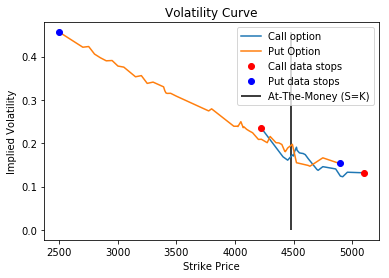

In [487]:
plt.plot(callData[0], callData[2],label="Call option")
plt.plot(callData_1[0], callData_1[2],label="Put Option")
plt.vlines(S,0,(max(callData_1[2]),max(yIV)),label="At-The-Money (S=K)")
plt.plot([strikes[0],strikes[len(strikes)-1]],[callData[2][0],callData[2][len(strikes)-1]],"ro",label="Call data stops")
plt.plot([pstrikes[0],pstrikes[len(pstrikes)-1]],[callData_1[2][0],callData_1[2][len(pstrikes)-1]],"bo",label="Put data stops")
plt.title("Volatility Curve")
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
# plt.xlim(lowerlim,upperlim)
plt.legend()
plt.show()

### Mixture of Modified (Bisection + Newton Raphson) + starting sigma sensitivity + tuning paramater for bracketing

# Are we getting anything different with closed form approx of sigma with sigma sensitivity 

In [515]:
sigmaImplied = np.zeros(len(price))
sigmaImplied_1 = np.zeros(len(pprice)) #variable to see effects of tol & max_iterations 
#From left tail to right tail
for i in range(0,len(price)):
        sigma1=np.sqrt((2*np.pi)/ttm[index])*price[i]/S  #BRENNERS INITIAL ESTIMATE
        sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=20)
#         sigmaImplied_1[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.00001,max_iterations=20)

        restart = 0 # Restart with more previous estimates
        if (np.isnan(sigmaImplied[i])==True):
            sigmaImplied[i] = ivVer3(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=20,tune_limit=10) 
#             sigmaImplied_1[i] = ivVer3(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.00001,max_iterations=20,tune_limit=10)

            restart += 1
        if sigmaImplied[i] <0.001:
            sigmaImplied[i]=sigma1
#From left tail to right tail
for i in range(0,len(pprice)):
        sigma1=np.sqrt((2*np.pi)/ttm[index])*pprice[i]/S  #BRENNERS INITIAL ESTIMATE
#         sigmaImplied[i] = impliedVol(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=20)
        sigmaImplied_1[i] = impliedVol(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.00001,max_iterations=20)

        restart = 0 # Restart with more previous estimates
        if (np.isnan(sigmaImplied_1[i])==True):
#             sigmaImplied[i] = ivVer3(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=20,tune_limit=10) 
            sigmaImplied_1[i] = ivVer3(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.00001,max_iterations=20,tune_limit=10,option="put")

            restart += 1
        if sigmaImplied_1[i] <0.001:
            sigmaImplied_1[i]=sigma1

C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\arinj

hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
found on 5th iteration


C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: overflow encountered in double_scalars


difference is equal to 1.0610460776661057e-05

hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
hallelujah1
found on 4th iteration
difference is equal to 3.69633767149935e-05

found on 5th iteration
difference is equal to 2.017486622207798e-09

hallelujah1
hallelujah1
found on 5th iteration
difference is equal to 1.0449639376020059e-08

hallelujah1
found on 4th iteration
difference is equal to 1.9676243027788587e-05

hallelujah1
hallelujah1
found on 4th iteration
difference is equal to 1.2594548479682999e-06

found on 4th iteration
difference is equal to 4.925850589643233e-07

found on 4th iteration
difference is equal to 1.5802470443304628e-09

found on 4th iteration
difference is equal to 5.377851266530342e-07

found on 4th iteration
difference is equal to 2.3463121578970458e-07

found on 4th iteration
difference is equal to 2.3237589630298316e-10

found on 4th iteration
difference is equal to 1.0600160749163479e-09

found on 4th iteration
differenc

C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: overflow encountered in double_scalars
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: overflow encountered in double_scalars


hallelujah1
BOO    
  found on 0.32000000000000006th iteration
BOO      target price difference is equal to -2.6511190030831244e-05

hallelujah1
BOO    
  found on 0.32000000000000006th iteration
BOO      target price difference is equal to -6.995042710755683e-05

hallelujah1
BOO    
  found on 0.32000000000000006th iteration
BOO      target price difference is equal to -6.259803113550788e-05

hallelujah1
BOO    
  found on 0.32000000000000006th iteration
BOO      target price difference is equal to -5.152733216107208e-05

hallelujah1
BOO    
  found on 0.32000000000000006th iteration
BOO      target price difference is equal to 9.537334367148986e-05

hallelujah1
BOO    
  found on 0.32000000000000006th iteration
BOO      target price difference is equal to -7.444023015512613e-05

hallelujah1
BOO    
  found on 1.6200000000000006th iteration
BOO      target price difference is equal to -8.254162275983523e-06

hallelujah1
BOO    
  found on 1.4200000000000004th iteration
BOO      target

In [516]:
# get rid of nans so we can plot
ind = np.where(~np.isnan(sigmaImplied))
ind_1 = np.where(~np.isnan(sigmaImplied_1))
# view our estimates
print(sigmaImplied)
print(sigmaImplied_1)

[1.58346043 1.54674894 1.52343359 1.45393571 1.45494033 1.42349468
 1.32307026 1.287031   1.27352281 1.17133191 1.04331225 1.10496739
 1.06956302 1.06160824 0.94662994 1.00327319 0.98579509 0.97383677
 0.95639601 0.91953887 0.68399898 0.81165264 0.63772681 0.6533376
 0.77867205 0.22948713 0.7209719  0.70887167 0.5150066  0.61905362
 0.63324524 0.61677549 0.4396416  0.50903118 0.23596786 0.21115844
 0.51468916 0.48550296 0.18438473 0.49700565 0.20595244 0.51538006
 0.37150313 0.20381479 0.20537864 0.23459359 0.19659608 0.19719361
 0.23131039 0.20900731 0.21399914 0.17752358 0.19638947 0.24745712
 0.27120942 0.20955309 0.30883964 0.22075848 0.29604477 0.29211966
 0.11762606 0.16504768 0.06573178 0.20790846 0.16592824 0.20644192
 0.16291586 0.20195881 0.10466349 0.20858218 0.11108476 0.19328536
 0.13815092 0.17238386 0.1545557  0.19347377 0.16669969 0.18520657
 0.17570337 0.18214661 0.18909502 0.18988817 0.13276473 0.18781262
 0.18335698 0.16945209 0.16394083 0.17584732 0.15788614 0.17532

In [517]:
# Get values in dataframe to plot easily
callData = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1 = pd.concat([pd.Series(pstrikes[ind_1]), pd.Series(pprice[ind_1]), pd.Series(sigmaImplied_1[ind_1])], axis=1)

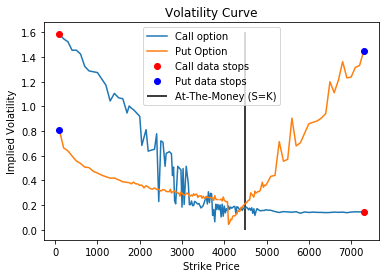

In [520]:
plt.plot(callData[0], callData[2],label="Call option")
plt.plot(callData_1[0], callData_1[2],label="Put Option")
plt.vlines(S,0,1.6,label="At-The-Money (S=K)")
plt.plot([strikes[0],strikes[len(strikes)-1]],[callData[2][0],callData[2][len(strikes)-1]],"ro",label="Call data stops")
plt.plot([pstrikes[0],pstrikes[len(pstrikes)-1]],[callData_1[2][0],callData_1[2][len(pstrikes)-1]],"bo",label="Put data stops")
plt.title("Volatility Curve")
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
# plt.xlim(lowerlim,upperlim)
plt.legend()
plt.show()

1.2925788045063489

# We are interested in some hybrid optimiser so found Brent's Method - Mixture of Secant, Bisection and inverse quadratic interpolation

In [521]:
def brentm(target, S, K, T, r, sigma=0.5, option ="call", tol=0.000001, max_iterations=100,tune_limit = 0.4):

        sigma0=sigma
        tune = .5 # Need starting tune
        a = sigma0-tune
        b= sigma0+tune
#         if a <0:
#             a=0.00001
        diff1 = bs(S, K, T, r, a, option) - target
        diff2 = bs(S, K, T, r, b, option) - target
    
        
        while (diff1*diff2>0) and (tune<tune_limit):
                    tune += .1 #Increasing from both sides
                    a = sigma - tune
#                     if a<0:
#                         a =0.00000000000000000001
                    b = sigma + tune
                    diff1 = bs(S, K, T, r, a, option) - target
                    diff2 = bs(S, K, T, r, b, option) - target
        
        tester = 0
        testlimit =100
        gridcheck = np.linspace(0,b-a,testlimit)
        for i in gridcheck:
                difftest = bs(S, K, T, r, a+i, option) - target
                while ((diff1*difftest < 0) and (diff2*difftest < 0) and (tester < testlimit)): 
                            length = b-a 
                            bnew = b * (1 - (length)*(tester/tester_limit)) #decrease interval 2% each time from RHS
                            diff2 = bs(S, K, T, r, bnew, option) - target
                            tester+=1
                            if (((diff1*difftest > 0) and (diff2*difftest < 0)) or ((diff1*difftest < 0) and (diff2*difftest > 0)))  :  
                                b = bnew   
        #                         difftest = bs(S, K, T, r, (a+b)/2, option) - target
                                print("hallelujah2")

        def bs_1(vol):
            return bs(S, K, T, r, vol, option) - target
        
        return brentq(bs_1,a,b,maxiter=max_iterations,disp=False)

### First with sigma incremental sensitivity

In [337]:
startindex = abs(S-strikes).argmin() #starting index
# IV for each strike price at the choosen maturity date
sigmaImplied = np.zeros(len(price))
sigmaImplied_1 = np.zeros(len(price)) #variable to see effects of tol & max_iterations 
#Initial sigma 
sigma0 = brentm(target=price[startindex], S=S, K=strikes[startindex], T=ttm[index], r=rNew[index], sigma=0.5,tol=0.0001,max_iterations=1000,tune_limit=2)
sigmaImplied[startindex] = sigma0
sigmaImplied_1[startindex] = sigma0

#Right Tail
for i in range(startindex+1,len(price)):
    
        sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1],tol=0.0001,max_iterations=1000,tune_limit=10)
        sigmaImplied_1[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1],tol=0.000000001,max_iterations=1000,tune_limit=10)

#         restart = 0 # Restart with more previous estimates
#         while (sigmaImplied[i]<0.0000001) and (restart<20): #Stops very small sigmas being accepted, tries again with sensitivity
#             back =0
#             while np.isnan(sigmaImplied[i-1-back]) == True:
#                 back+=1
#             sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i-1-back]+restart/100,tol=0.0001,max_iterations=100,tune_limit=.3) 
#             sigmaImplied_1[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i-1-back]+restart/100,tol=0.0000001,max_iterations=100,tune_limit=3)

#             restart += 1

#Left Tail
for i in range(startindex-1,-1,-1):
        sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i+1],tol=0.000001,max_iterations=100000,tune_limit=50)
        sigmaImplied_1[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i+1],tol=0.000001,max_iterations=100000,tune_limit=100)

#         restart = 0 # Restart with more previous estimates
#         restart_limit = 20
#         while (sigmaImplied[i]<0.0000001): #and (restart<restart_limit):
#             back =0
#             while np.isnan(sigmaImplied[i+1+back]) == True:
#                 back+=1
                
#             sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied[i+1+back]-restart/100,tol=0.0001,max_iterations=1000,tune_limit=10) 
#             sigmaImplied_1[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigmaImplied_1[i+1+back]-restart/100,tol=0.0000001,max_iterations=1000,tune_limit=10)
#             restart += 1

C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


In [338]:
# get rid of nans so we can plot
ind = np.where(~np.isnan(sigmaImplied))
ind_1 = np.where(~np.isnan(sigmaImplied_1))
# view our estimates
print(sigmaImplied)
print(sigmaImplied_1)

[4.35996848e-13 1.10201054e-12 3.15279324e-13 3.81682031e-13
 2.09597024e-01 2.31565385e-01 2.27853278e-01 1.06833902e-12
 4.41420315e-14 8.67837204e-13 1.66681460e-01 1.64313151e-01
 1.89158941e-01 1.66381534e-01 1.60617920e-01 1.86669018e-01
 1.70976972e-01 1.82263284e-01 1.64688412e-01 1.60735837e-01
 1.81099649e-01 2.02073489e-01 1.77196783e-01 1.97987582e-01
 1.78062247e-01 1.76369480e-01 9.00809345e-02 1.76076572e-01
 1.75148132e-01 1.74608363e-01 1.58255389e-01 1.59363257e-01
 1.68254548e-01 1.60993337e-01 1.67758832e-01 1.25480432e-01
 1.34707472e-01 1.34648912e-01 1.64430876e-01 1.63159552e-01
 1.26547087e-01 1.25714188e-01 1.60798628e-01 1.59300782e-01
 1.60339519e-01 1.59353151e-01 1.58916972e-01 1.31194086e-01
 1.31562912e-01 1.31555100e-01 1.71846557e-01 1.24726645e-01
 1.24393775e-01 1.69135253e-01 1.38281496e-01 1.37534019e-01
 1.45751200e-01 1.43090638e-01 1.57190401e-01 1.57815231e-01
 1.55046573e-01 1.54089213e-01 1.16874148e-01 1.20298559e-01
 1.52106220e-01 1.084725

In [339]:
# Get values in dataframe to plot easily
callData = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1 = pd.concat([pd.Series(strikes[ind_1]), pd.Series(price[ind_1]), pd.Series(sigmaImplied_1[ind_1])], axis=1)

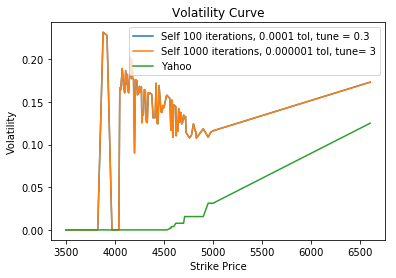

In [340]:
plt.plot(callData[0], callData[2],label="Self 100 iterations, 0.0001 tol, tune = 0.3")
plt.plot(callData_1[0], callData_1[2],label="Self 1000 iterations, 0.000001 tol, tune= 3")
plt.plot(strikes, yIV,label="Yahoo")
plt.title("Volatility Curve")
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
# plt.ylim((0,6))
plt.legend()
plt.show()

### Now we use closed form initial estimate of sigma volatility 

In [556]:
sigmaImplied = np.zeros(len(price))
sigmaImplied_1 = np.zeros(len(pprice)) #variable to see effects of tol & max_iterations 
#From left tail to right tail
for i in range(0,len(price)):
        sigma1=np.sqrt((2*np.pi)/ttm[index])*price[i]/S #BRENNERS INITIAL ESTIMATE
        sigma2=np.sqrt((2*np.pi)/ttm[index])*pprice[i]/S #BRENNERS INITIAL ESTIMATE
        sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=100,tune_limit=100)
        sigmaImplied_1[i] = brentm(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigma2,tol=0.00001,max_iterations=100,tune_limit=100,option="put")
        if (sigmaImplied[i]<0.00001):
#             sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=1000,tune_limit=20) 
#             sigmaImplied_1[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.00001,max_iterations=1000,tune_limit=20)
              sigmaImplied[i] = sigma1
        if sigmaImplied_1[i]<0.00001:
              sigmaImplied_1[i] = sigma2
for i in range(0,len(pprice)):
#         sigma1=np.sqrt((2*np.pi)/ttm[index])*price[i]/S #BRENNERS INITIAL ESTIMATE
        sigma2=np.sqrt((2*np.pi)/ttm[index])*pprice[i]/S #BRENNERS INITIAL ESTIMATE
#         sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=100,tune_limit=100)
        sigmaImplied_1[i] = brentm(target=pprice[i], S=S, K=pstrikes[i], T=ttm[index], r=rNew[index], sigma=sigma2,tol=0.00001,max_iterations=100,tune_limit=100,option="put")
#         if (sigmaImplied[i]<0.00001):
# #             sigmaImplied[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.0001,max_iterations=1000,tune_limit=20) 
# #             sigmaImplied_1[i] = brentm(target=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], sigma=sigma1,tol=0.00001,max_iterations=1000,tune_limit=20)
#               sigmaImplied[i] = sigma1
        if sigmaImplied_1[i]<0.00001:
              sigmaImplied_1[i] = sigma2       

In [557]:
# get rid of nans so we can plot
ind = np.where(~np.isnan(sigmaImplied))
ind_1 = np.where(~np.isnan(sigmaImplied_1))
# view our estimates
print(sigmaImplied)
print(sigmaImplied_1)

[0.23487668 0.16870196 0.16095265 0.17309131 0.17047782 0.18155701
 0.19090023 0.18389718 0.1777946  0.1764983  0.17652853 0.17372726
 0.16451895 0.13939892 0.13754868 0.14591744 0.14548572 0.14069812
 0.12421056 0.12265935 0.13312319 0.13178348]
[0.45612587 0.42157236 0.42317355 0.40573289 0.39721734 0.39020874
 0.39086392 0.37808405 0.37565374 0.35335674 0.35603866 0.3381109
 0.34107903 0.33011178 0.32138059 0.31611075 0.31503977 0.31526229
 0.30850444 0.27456721 0.27940944 0.23921221 0.2392411  0.23860259
 0.24974412 0.23599015 0.23811508 0.23202615 0.22787049 0.2242478
 0.20879393 0.209198   0.20128313 0.21567062 0.20124239 0.20074963
 0.19713686 0.18140967 0.18059597 0.18903881 0.19760622 0.15506199
 0.14880249 0.14694748 0.1663475  0.15448704 0.15460207]


In [558]:
# Get values in dataframe to plot easily
callData = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1 = pd.concat([pd.Series(pstrikes[ind_1]), pd.Series(pprice[ind_1]), pd.Series(sigmaImplied_1[ind_1])], axis=1)

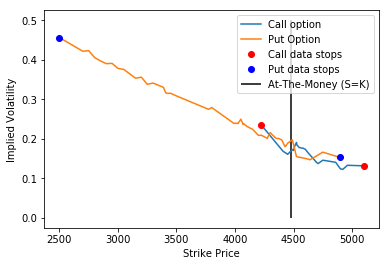

In [560]:
plt.plot(callData[0], callData[2],label="Call option")
plt.plot(callData_1[0], callData_1[2],label="Put Option")
plt.vlines(S,0,0.5,label="At-The-Money (S=K)")
plt.plot([strikes[0],strikes[len(strikes)-1]],[callData[2][0],callData[2][len(strikes)-1]],"ro",label="Call data stops")
plt.plot([pstrikes[0],pstrikes[len(pstrikes)-1]],[callData_1[2][0],callData_1[2][len(pstrikes)-1]],"bo",label="Put data stops")
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
# plt.xlim(lowerlim,upperlim)
plt.legend()
plt.show()

### Behaving the same, with sigma sensitivity and usage of closed form initial estimate.

# Rational Approximation Method

COMMENTED CODE IS THE IMPLEMENTATION OF THE APPROXIMATION OF THE 31 parameters but this is already given in the paper By Li[2006]

In [20]:
# def unpacker(initial):
#     #Unpack 
#     p1=initial[0]
#     p2=initial[1]
#     p3=initial[2]
#     n = np.zeros((5,5))
#     m = np.zeros((5,5))
#     n[0,:]=initial[3:3+5]
#     n[1,:]=initial[8:8+5]
#     n[2,:]=initial[13:13+5]
#     n[3,:]=initial[18:18+5]
#     n[4,:]=initial[23:23+5]
#     n[0,0] = 0
#     n[1,4] = 0
#     n[2,3] = 0
#     n[2,4] = 0
#     n[3,2] = 0
#     n[3,3] = 0
#     n[3,4] = 0
#     n[4,1] = 0
#     n[4,2] = 0
#     n[4,3] = 0
#     n[4,4] = 0
    
#     m[0,:]=initial[28:28+5]
#     m[1,:]=initial[33:33+5]
#     m[2,:]=initial[38:38+5]
#     m[3,:]=initial[43:43+5]
#     m[4,:]=initial[48:48+5]
#     m[0,0] = 0
#     m[1,4] = 0
#     m[2,3] = 0
#     m[2,4] = 0
#     m[3,2] = 0
#     m[3,3] = 0
#     m[3,4] = 0
#     m[4,1] = 0
#     m[4,2] = 0
#     m[4,3] = 0
#     m[4,4] = 0
#     return p1,p2,p3,n,m

In [21]:
# # First we get observed normalised call price
# def normc(option_price,S,ttm):
#     return option_price / (S)
    
# # Moneyness
# def x(S,K,r,ttm):
#     return np.log(S*np.exp(r*ttm)/K)

# # Approximate integrated volatility function
# def rationalApprox_v(observed_moneyness,observed_normalised_callprice,initial):
#     p1,p2,p3,n,m = unpacker(initial)    
    
#     collection1 = 0
#     collection2 = 1
#     for i in range(0,len(n)):
#         for j in range(0,len(m)):
#             if ((i + j)>=1) and ((i + j)<=4):
#                 temp1 = n[i,j] * (observed_moneyness**(i)) * (np.sqrt(observed_normalised_callprice)**(j))
#                 temp2 = m[i,j] * (observed_moneyness**(i)) * (np.sqrt(observed_normalised_callprice)**(j))
#                 collection1 += temp1
#                 collection2 += temp2  
#     return p1*observed_moneyness + p2*np.sqrt(observed_normalised_callprice) + p3*observed_normalised_callprice + ((collection1)/(collection2))

# # theoretical_normalised_c
# def theoretical_normalised_c(x,v):
#     return norm.cdf((x/v) + (v/2)) - np.exp(-x)*norm.cdf((x/v) - (v/2))

# def setupmesh(mesh):
#     cvals = np.zeros((mesh,mesh))
#     xvals = np.linspace(-2,0,mesh)  
#     vvals = np.linspace(0.0001,1,mesh)
    
#     for i in range(0,mesh):
#         cvals[i,:]= theoretical_normalised_c(xvals,vvals[i])
            
#     return xvals, vvals, cvals 

# # Check if our options are in the domain otherwise invert
# def domainD_check(observed_moneyness,observed_normalised_c):
#     check1 = 0
#     check2 = 0
#     if (observed_moneyness >= 0):
#         observed_moneyness = -observed_moneyness
#         observed_normalised_c = np.exp(-observed_moneyness)*observed_normalised_c + 1 - np.exp(-observed_moneyness)
# #         print("ok")
#     if (observed_normalised_c <= theoretical_normalised_c(observed_moneyness,1)) and (observed_normalised_c >= theoretical_normalised_c(observed_moneyness,-observed_moneyness/2)):
#         check2+=1
# #         print("ok2")
#     return observed_moneyness, observed_normalised_c


# #Objective function to minimize
# def objective(initial,*args):    
    
#     # Args to completely specify arguments
# #     price = args[0]
#     lamda = args[3]
# #     mesh = args[2]
# #     S = args[3]
# #     K = args[4]
# #     r = args[5]
# #     ttm = args[6]
    
#     # Set up the mesh domain
#     xvals = args[0]
#     vvals = args[1]
#     cvals= args[2]
    
#     # Calculate all cvals with approximate integrated volatility
    
#     ratv = np.ones((mesh,mesh))
#     cvals1 = np.ones((mesh,mesh))
#     for i in range(0,mesh):
#             ratv[i,:] = rationalApprox_v(xvals,cvals[i,:],x0)
#     ratv = ratv.mean(axis=1)
#     for i in range(0,len(ratv)):
#             cvals1[i,:] = theoretical_normalised_c(xvals,ratv[i])
#     # Make up the objective function

# #     for i in range(0,len(vvals)):    
# #             calc1 = sum(abs(cvals1[i,:]-cvals[i,:])**2)
# #             component1 += calc1
#     component1 = (abs(cvals1-cvals)**2).sum()
#     component2 = abs(cvals1 - cvals).max()
    
#     print(component1 + lamda*component2)
    
#     return component1 + lamda*component2
        

In [22]:
# # Downhill simplex method
# # Initial guess:
# x0=np.random.rand(53)*10
# # Other args:
# price1 = price[50]
# K = strikes[50]
# lamda = 0.5
# r = rNew[index]
# mesh = 100 # Meshsize
# xvals, vvals, cvals = setupmesh(mesh)
# minimum = minimize(objective,x0=x0,args=(xvals,vvals,cvals,lamda),method="Nelder-Mead",options={"maxiter":5,"disp":True})

In [48]:
# Rational Approximation Parameters from Li (2006)
n = np.zeros((5,5))
m = np.zeros((5,5))
n[0,1] = -0.068098378725
n[1,0] = 0.440639436211
n[0,2] = -0.263473754689
n[1,1] = -5.792537721792
n[2,0] = -5.267481008429
n[0,3] = 4.714393825758
n[1,2] = 3.529944137559
n[2,1] = -23.636495876611
n[3,0] = -9.020361771283
n[0,4] = 14.749084301452
n[1,3] = -32.570660102526
n[2,2] = 76.398155779133
n[3,1] = 41.855161781749
n[4,0] = -12.150611865704

m[0,1] = 6.268456292246
m[1,0] = -6.284840445036
m[0,2] = 30.068281276567
m[1,1] = -11.780036995036
m[2,0] = -2.310966989723
m[0,3] = -11.473184324152
m[1,2] = -230.101682610568 
m[2,1] = 86.127219899668
m[3,0] = 3.730181294225
m[0,4] = -13.954993561151
m[1,3] = 261.950288864225
m[2,2] = 20.090690444187
m[3,1]= -50.117067019539
m[4,0] = 13.723711519422
p1 =  -0.969271876255
p2 =  0.097428338274
p3 =  1.750081126685


In [49]:
# First we get observed normalised call price
def normc(option_price,S):

    return option_price / S

# theoretical_normalised_c
def theoretical_normalised_c(x,v):
    return norm.cdf((x/v) + (v/2)) - np.exp(-x)*norm.cdf((x/v) - (v/2))  

# Moneyness
def x(S,K,r,ttm):
    return np.log(S*np.exp(r*ttm)/K)

def domainD_check(observed_moneyness,observed_normalised_c):
    check1 = 0
    check2 = 0
    if (observed_moneyness >= 0):
        observed_moneyness = -observed_moneyness
        observed_normalised_c = np.exp(-observed_moneyness)*observed_normalised_c + 1 - np.exp(-observed_moneyness)
        
    if (observed_normalised_c <= theoretical_normalised_c(observed_moneyness,(observed_moneyness)/2)):
        #Newton Raphson here if this is broken - rare
        
        print("FLAG")
    return observed_moneyness, observed_normalised_c

def rationalApprox_v1(x,c,p1,p2,p3,m,n): 
    
    collection1 = 0
    collection2 = 1
    for i in range(0,len(n)):
        for j in range(0,len(m)):
            if ((i + j)>=1) and ((i + j)<=4):
                temp1 = n[i,j] * (x**(i)) * (np.sqrt(abs(c))**(j))
                temp2 = m[i,j] * (x**(i)) * (np.sqrt(abs(c))**(j))
                collection1 += temp1
                collection2 += temp2

    return p1*x + p2*np.sqrt(abs(c)) + p3*c + ((collection1)/(collection2))

In [50]:
# test the vol
# Other args:
ttm1=ttm[index]
r=rNew[index]
imp=np.zeros(len(price))
imp1=np.zeros(len(pprice))
for i in range(0,len(imp)):
    moneyness, normalised_c= domainD_check(x(S,strikes[i],r,ttm1),normc(price[i],S))
    imp[i]=rationalApprox_v1(moneyness,normalised_c,p1,p2,p3,m,n)/np.sqrt(ttm1)
for i in range(0,len(imp1)):
    moneyness_1, normalised_c_1= domainD_check(x(S,pstrikes[i],r,ttm1),normc(pprice[i]-(+ ( np.exp(-r * ttm1) * pstrikes[i] ) - S),S))
    imp1[i]=rationalApprox_v1(moneyness_1,normalised_c_1,p1,p2,p3,m,n)/np.sqrt(ttm1)
                                                                    

for i in range(0,len(imp)):
    moneyness, normalised_c= domainD_check(x(S,strikes[i],r,ttm1),normc(price[i],S))
#     imp[i]=rationalApprox_v1(x(S,strikes[i],r,ttm),normc(price[i],S),p1,p2,p3,m,n)/np.sqrt(ttm)
    imp[i]=rationalApprox_v1(moneyness,normalised_c,p1,p2,p3,m,n)/np.sqrt(ttm1)

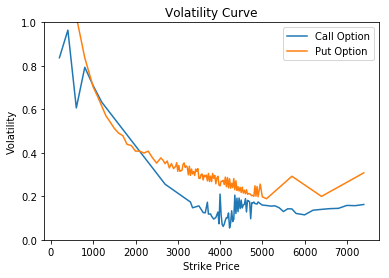

In [51]:
plt.plot(strikes, imp,label="Call Option")
plt.plot(pstrikes, imp1,label="Put Option")
# plt.plot(callData_1[0], callData_1[2],label="Self 1000 iterations, 0.000001 tol, tune= 3")
# plt.plot(strikes, yIV,label="Yahoo")
plt.title("Volatility Curve")
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.ylim(0,1)
plt.legend()
plt.show()

# Closed form through delta families

In [73]:
# Volatility Bounds
#Normalised call price
def normc(option_price,S):
    return option_price / S

# Moneyness
def x(S,K,r,ttm):
    return np.log(K/(S*np.exp(r*ttm)))

def bounds(normalised_c,moneyness,ttm):
    upper = (-2/np.sqrt(ttm))*norm.ppf((1-normalised_c)/(1+np.exp(moneyness)))
    if moneyness >=0:
        lower = (-2/np.sqrt(ttm))*norm.ppf((1-normalised_c)/(2))
    elif moneyness < 0:
        lower = (-2/np.sqrt(ttm))*norm.ppf((1-normalised_c)/(2*np.exp(moneyness)))
    return upper, lower
        
def vol_calc(obs_price,S,K,T,r,epsilon):
    term1 = (S*np.sqrt(T)) / (2*np.sqrt(2*epsilon)*np.pi)
    moneyness = x(S,K,r,T)
    normalised_c = normc(obs_price,S)
    upper, lower = bounds(normalised_c,moneyness,T)
    dv = 1/50
    spaces=np.linspace(lower,upper,int(1/dv))
    term2 = 0
    for i in spaces:
#         dplus = (-moneyness/(i*np.sqrt(T))) + ((i*np.sqrt(T))/2)
#         dminus = (-moneyness/(i*np.sqrt(T))) - ((i*np.sqrt(T))/2 )
        d1 = (np.log(S/K) + (r + 0.5*i**2)*T) / (i*np.sqrt(T))
        exponent=np.exp(((- (bs(S, K, T, r, i, option="call") - obs_price)**(2) )/(4*epsilon)) - (d1**(2)/2))
        term2 += dv*i*exponent
    
    ep = 0.1
    vol = term1*term2
    while ((vol<lower) or (vol>upper)) and (ep<10e10):
        upper, lower, vol = vol_calc(obs_price=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], epsilon=1/ep)
        if vol == 0:
            vol = (upper+lower)/2
        ep*=10
    return vol

In [77]:
ep=0.01

upper, lower, vol = vol_calc(obs_price=price[14], S=S, K=strikes[14], T=ttm[index], r=rNew[index], epsilon=1/ep)
while ((vol<lower) or (vol>upper)) and (ep<10e10):
    ep*=10
    upper, lower, vol = vol_calc(obs_price=price[14], S=S, K=strikes[14], T=ttm[index], r=rNew[index], epsilon=1/ep)
vol
              
                                 

TypeError: 'numpy.float64' object is not iterable

In [76]:
sigmaImplied = np.zeros(len(price))
sigmaImplied_1 = np.zeros(len(price)) #variable to see effects of tol & max_iterations 
#From left tail to right tail
for i in range(0,len(price)):
        ep = 0.0001
        upper, lower, vol = vol_calc(obs_price=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], epsilon=ep)
        while ((vol<lower) or (vol>upper)) and (ep<10e10):
            ep*=10
            upper, lower, vol = vol_calc(obs_price=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], epsilon=ep)
        if vol == 0:
            vol = (upper+lower)/2
        sigmaImplied[i] = vol
            
#   sigmaImplied_1[i] = vol_calc(obs_price=price[i], S=S, K=strikes[i], T=ttm[index], r=rNew[index], epsilon = 0.2)

TypeError: 'numpy.float64' object is not iterable

In [67]:
# get rid of nans so we can plot
ind = np.where(~np.isnan(sigmaImplied))
ind_1 = np.where(~np.isnan(sigmaImplied_1))
# view our estimates
print(sigmaImplied)
print(sigmaImplied_1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [68]:
# Get values in dataframe to plot easily
callData = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1 = pd.concat([pd.Series(strikes[ind_1]), pd.Series(price[ind_1]), pd.Series(sigmaImplied_1[ind_1])], axis=1)

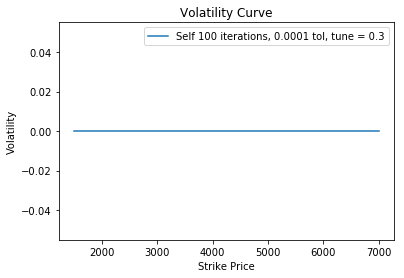

In [69]:
plt.plot(callData[0], callData[2],label="Self 100 iterations, 0.0001 tol, tune = 0.3")
# plt.plot(callData_1[0], callData_1[2],label="Self 1000 iterations, 0.000001 tol, tune= 3")
# plt.plot(strikes, yIV,label="Yahoo")
plt.title("Volatility Curve")
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
# plt.ylim((0,1))
plt.legend()
plt.show()

# Varying r with optimal NR method found

In [ ]:
r = rNew[index] 
r = np.linspace(r-0.001,r+0.001,5)
r

In [ ]:
rNew[index]

In [ ]:
r[0]=0
r[2]= rNew[index]
r[4]= 0.001
sigmaImpliedr0, sigmaImplied_1r0 = IV(r[0])
sigmaImpliedr1, sigmaImplied_1r1 = IV(r[1])
sigmaImpliedr2, sigmaImplied_1r2 = IV(r[2])
sigmaImpliedr3, sigmaImplied_1r3 = IV(r[3])
sigmaImpliedr4, sigmaImplied_1r4 = IV(r[4])

In [ ]:
indr0 = np.where(~np.isnan(sigmaImpliedr0))
ind_1r0 = np.where(~np.isnan(sigmaImplied_1r0))

indr1 = np.where(~np.isnan(sigmaImpliedr1))
ind_1r1 = np.where(~np.isnan(sigmaImplied_1r1))

indr2 = np.where(~np.isnan(sigmaImpliedr2))
ind_1r2 = np.where(~np.isnan(sigmaImplied_1r2))

indr3 = np.where(~np.isnan(sigmaImpliedr3))
ind_1r3 = np.where(~np.isnan(sigmaImplied_1r3))

indr4 = np.where(~np.isnan(sigmaImpliedr4))
ind_1r4 = np.where(~np.isnan(sigmaImplied_1r4))

In [ ]:
# callDatar0 = pd.concat([pd.Series(strikes[indr0]), pd.Series(price[indr0]), pd.Series(sigmaImpliedr0[indr0])], axis=1)
callData_1r0 = pd.concat([pd.Series(strikes[ind_1r0]), pd.Series(price[ind_1r0]), pd.Series(sigmaImplied_1r0[ind_1r0])], axis=1)

# callDatar1 = pd.concat([pd.Series(strikes[indr1]), pd.Series(price[ind]), pd.Series(sigmaImpliedr1[ind])], axis=1)
callData_1r1 = pd.concat([pd.Series(strikes[ind_1r1]), pd.Series(price[ind_1r1]), pd.Series(sigmaImplied_1r1[ind_1r1])], axis=1)

# callDatar2 = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImpliedr[ind])], axis=1)
callData_1r2 = pd.concat([pd.Series(strikes[ind_1r2]), pd.Series(price[ind_1r2]), pd.Series(sigmaImplied_1r2[ind_1r2])], axis=1)

# callDatar3 = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1r3 = pd.concat([pd.Series(strikes[ind_1r3]), pd.Series(price[ind_1r3]), pd.Series(sigmaImplied_1r3[ind_1r3])], axis=1)

# callDatar4 = pd.concat([pd.Series(strikes[ind]), pd.Series(price[ind]), pd.Series(sigmaImplied[ind])], axis=1)
callData_1r4 = pd.concat([pd.Series(strikes[ind_1r4]), pd.Series(price[ind_1r4]), pd.Series(sigmaImplied_1r4[ind_1r4])], axis=1)

In [ ]:

plt.figure(figsize=(16,8))
plt.plot(callData_1r0[0], callData_1r0[2],label="r = {}".format(r[0]))
plt.plot(callData_1r1[0], callData_1r1[2],label="r = {}".format(r[1]))
# plt.plot(callData_1r2[0], callData_1r2[2],label="r = {}".format(r[2]))
# plt.plot(callData_1r3[0], callData_1r3[2],label="r = {}".format(r[3]))
plt.plot(callData_1r4[0], callData_1r4[2],label="r = {}".format(r[4]))
# plt.plot(strikes, IV,label="Yahoo")
plt.plot([S]*len(callData_1r0[2]),callData_1r0[2]) #Share price - at the money
plt.title("Volatility Curve")
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.ylim((0,2))
plt.legend()
plt.show()

In [ ]:
sigmaImplied_1r4